In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

Now let's download the weights:

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-12-14 14:49:22--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.203.16, 216.58.203.48, 142.250.67.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.203.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  9.81MB/s    in 9.2s    

2020-12-14 14:49:32 (9.09 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [12]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Now let's stick a fully connected classifier on top of `last_output`:

In [14]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [15]:
# !wget --no-check-certificate \
#    https://dataset1523.s3.ap-south-1.amazonaws.com/PetImages.zip -O \
#    /tmp/PetImages.zip

In [16]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# local_zip = './PetImages.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

# Define our example directories and files
base_dir = './PetImages'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_Cat_dir = os.path.join(train_dir, 'Cat')

# Directory with our training dog pictures
train_Dog_dir = os.path.join(train_dir, 'Dog')

# Directory with our validation cat pictures
validation_Cat_dir = os.path.join(validation_dir, 'Cat')

# Directory with our validation dog pictures
validation_Dog_dir = os.path.join(validation_dir, 'Dog')

train_cat_fnames = os.listdir(train_Cat_dir)
train_dog_fnames = os.listdir(train_Dog_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 19762 images belonging to 2 classes.
Found 2670 images belonging to 2 classes.


In [17]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [18]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=617,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=83,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
 80/617 [==>...........................] - ETA: 8:11 - loss: 0.6996 - acc: 0.5118

/home/sarvesh/anaconda3/envs/kevin/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/sarvesh/anaconda3/envs/kevin/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/sarvesh/anaconda3/envs/kevin/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/sarvesh/anaconda3/envs/kevin/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/sarvesh/anaconda3/envs/kevin/lib/python3.

617/617 [==============================] - 597s 968ms/step - loss: 0.6524 - acc: 0.6282 - val_loss: 0.5738 - val_acc: 0.7907
Epoch 2/5
617/617 [==============================] - 515s 835ms/step - loss: 0.5749 - acc: 0.7559 - val_loss: 0.4871 - val_acc: 0.8682
Epoch 3/5
617/617 [==============================] - 510s 826ms/step - loss: 0.5161 - acc: 0.8118 - val_loss: 0.4234 - val_acc: 0.8882
Epoch 4/5
617/617 [==============================] - 508s 824ms/step - loss: 0.4709 - acc: 0.8340 - val_loss: 0.3733 - val_acc: 0.9051
Epoch 5/5
617/617 [==============================] - 648s 1s/step - loss: 0.4331 - acc: 0.8505 - val_loss: 0.3293 - val_acc: 0.9191


Text(0.5, 1.0, 'Training and validation loss')

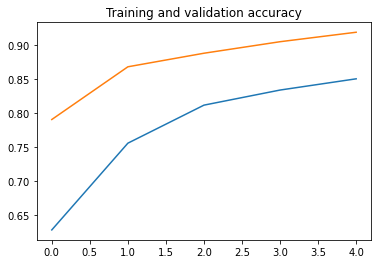

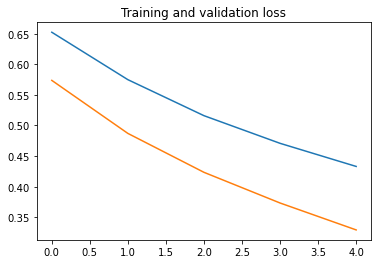

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Congratulations! Using feature extraction and fine-tuning, you've built an image classification model that can identify leaves vs. no_leaves in images with over 90% accuracy.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [20]:
model.save(r'./inception_v3_150x150_v1.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./inception_v3_150x150_v1.model/assets


## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

In [33]:
import numpy as np
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [34]:
# from google.colab import drive
# drive.mount('/gdrive')

In [35]:
# /gdrive/My Drive/tomato_virus_project/inception_v3.model
# /gdrive/My Drive/tomato_virus_project/inception_v3_299x299.model

In [36]:
!ls

11023.jpg  Cat_vs_Dog_classification.ipynb  model.py   PetImages.zip
app.py	   inception_v3_150x150_v1.model    PetImages


In [37]:
model = load_model("./inception_v3_150x150_v1.model")

In [44]:
img_path = './11714.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
print(preds[0][0])
if preds[0][0] < 0.65:
    print ("Cat")
else:
    print ("Dog")
# print('Predicted:', decode_predictions(preds))

0.8761896
Dog
